In [1]:
import sys
import langid
import os
import itertools
from operator import itemgetter
import networkx as nx
import stemming.porter2 as porter
from stanfordcorenlp import StanfordCoreNLP

tokenizer = StanfordCoreNLP("http://localhost")
stem = porter.stem

In [25]:
import json

datanames = ['nus', 'semeval-2010']
storiesMap = {}

for dataset in datanames:
    infilename  = '../datasets/%s-standard.json' % dataset
    with open(infilename) as f:
        stories = json.loads(f.read())
    storiesMap[dataset] = stories   
print(storiesMap.keys())
print(storiesMap[datanames[0]][1].keys())

for dataset, stories in storiesMap.items(): 
    for idx, story in enumerate(stories):
        for entity in story['entities']:
            words = tokenizer.word_tokenize(entity['id'])
            entity['stemmed_id'] = ' '.join([stem(word).lower() for word in words])
            story['suid'] = idx
        
        # gr only once
        entities = [entity['stemmed_id'] for entity in story['entities']]
        seen = set()
        story['entities'] = [x for x in entities if not (x in seen or seen.add(x))]
                    
        ## ground truth -- only entities which appear in story
#         story_stemmed = ' '.join([stem(word).lower() for word in 
#                          tokenizer.word_tokenize(story['headline'] + '\n' + story['body'])])
        story['all_gr'] = story['entities']
        story['true_gr'] = [entity for entity in story['entities'] if entity in story['stemmed_content']]
        sys.stdout.write('\r %s story %d/%d [entities count: %d]'% (dataset, idx, len(stories), len(story['true_gr'])))
    print('')

dict_keys(['nus', 'semeval-2010'])
dict_keys(['headline', 'body', 'entities', 'stemmed_content'])
 nus story 182/183 [entities count: 10]
 semeval-2010 story 243/244 [entities count: 16]


In [26]:
for dataset, stories in storiesMap.items():
    total = 0
    present = 0
    for story in stories:
        total += len(story['all_gr'])
        present += len(story['true_gr'])
    print(dataset.upper())
    print('total: %d, present: %d, ratio: %.3f' % (total, present, present/total))

NUS
total: 2008, present: 1737, ratio: 0.865
SEMEVAL-2010
total: 3615, present: 3148, ratio: 0.871


NUS
not_found:  jump=1,edge=1 []
not_found:  jump=pos,edge=1 []
not_found:  jump=1,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.7 []
not_found:  jump=pos,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.7 []
not_found:  jump=1,edge=C_100_train_0.8++_dep_all_a=0.0005_t []
not_found:  jump=pos,edge=C_100_train_0.8++_dep_all_a=0.0005_t []
TEST  stories [37]
[20, 35, 153, 79, 129, 82, 168, 138, 39, 159, 163, 80, 21, 18, 73, 13, 30, 108, 181, 155, 115, 173, 91, 54, 98, 135, 85, 162, 47, 40, 145, 100, 67, 45, 32, 105, 66]

NUS  exact_match: True TEST true_gr
+----------------------------------+-----+-----+-----+-----+-----+-----+------+------+------+
|               algo               | :2  | :4  | :6  | :8  | :10 | :12 | :16  | :20  | max  |
+==================================+=====+=====+=====+=====+=====+=====+======+======+======+
| jump=1,edge=1                    | 4.3 | 5.3 | 6.7 | 7.5 | 7.9 | 8.1 | 8.8  | 8.1  | 8.8  |
+----------------------------------+-----+-----+-----+-----+-----+-

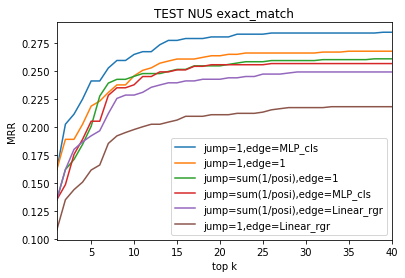

SEMEVAL-2010
not_found:  jump=1,edge=1 []
not_found:  jump=pos,edge=1 []
not_found:  jump=1,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.7 []
not_found:  jump=pos,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.7 []
not_found:  jump=1,edge=C_100_train_0.8++_dep_all_a=0.0005_t []
not_found:  jump=pos,edge=C_100_train_0.8++_dep_all_a=0.0005_t []
TEST  stories [49]
[232, 78, 185, 24, 2, 153, 56, 68, 129, 79, 31, 168, 37, 138, 202, 159, 34, 7, 163, 77, 186, 18, 237, 13, 195, 108, 181, 50, 155, 115, 173, 90, 218, 98, 135, 66, 3, 162, 69, 210, 67, 204, 145, 100, 230, 209, 197, 105, 23]

SEMEVAL-2010  exact_match: True TEST true_gr
+----------------------------------+-----+-----+-----+-----+-----+-----+------+------+------+
|               algo               | :2  | :4  | :6  | :8  | :10 | :12 | :16  | :20  | max  |
+==================================+=====+=====+=====+=====+=====+=====+======+======+======+
| jump=1,edge=1                    | 2.1 | 3.1 | 3.4 | 4.4 | 5.1 | 5.5 | 6.1  | 7.2  |

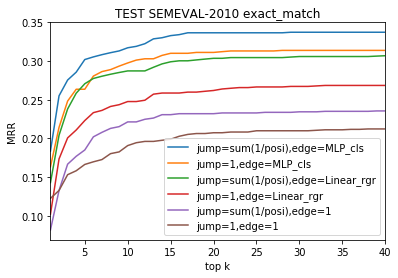

In [28]:
from functools import reduce
from scipy.stats import pearsonr
import sys
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import nltk
import common
import matplotlib as pyplot
import random
import importlib
importlib.reload(common)


def measureAgreement(dataset, stories_in, configs, exactMatch, test_mode, gr_label):
    # safe copy 
    stories = [story.copy() for story in stories_in]
    
    def included(gr, pred):
        gr_terms = gr.split(' ')
        pred_terms = pred.split(' ')
        if len(gr_terms) == 1:
            return gr == pred
        ## for bi-grams allow longer predictions
        diff = len(pred_terms) - len(gr_terms)
        if diff < 0:
            return False
        elif diff == 0:
            return pred_terms == gr_terms
        else:
            for i in range(diff+1):
                if gr_terms == pred_terms[i:i+len(gr_terms)]:
                    return True
            return False

    def equal(one, other):
        return one == other

    if exactMatch:
        compare = equal
    else:
        compare = included

    end_range = 41
    top_range = range(1, end_range)
    top_table_range = sorted([2, 6, 10] + list(range(4, 24, 4)))
    headers = ['algo'] + [':%d' % i for i in top_table_range] + ['max']
    rows = []
    MRR_map = {}

    def get_metrics(TP, FP, FN):
        P = TP / (TP + FP + sys.float_info.epsilon)
        R = TP / (TP + FN + sys.float_info.epsilon)
        F1 = 2 * 100 * P * R / (P + R + sys.float_info.epsilon)
        return F1, P, R

    for c_idx, config in enumerate(configs):
        for story in stories:
            if len(story[gr_label]) == 0:
                continue
            story[gr_label] = [' '.join([t for t in e.split(' ') if len(t) > 1]) for e in story[gr_label]]
            story[gr_label] = [e.lower() for e in story[gr_label] if len(e) > 0]
            
            story[config] = [e[0].lower() for e in story[config] if len(e) > 0]
            story[config] = [' '.join([t for t in e.split(' ') if len(t) > 1]) for e in story[config]]
            story[config] = [e for e in story[config] if len(e) > 1]
            
            seen = set()
            seen_add = seen.add
            story[config] = [x for x in story[config] if not (x in seen or seen_add(x))]
            
            for c in story[config]:
                for e in c.split(' '):
                    if len(e) <= 1:
                        print(c)
                        assert(False)
        
        row = [config]
        MRR_map[config] = []
        best_F1 = 0
        for top in top_range:
            TP = FP = FN = MRR = F1 = 0
            for story in stories:
                gr = story[gr_label]
                candidates = story[config][:top]
                TP_ = 0
                FP_ = 0
                FN_ = 0
                max_rank = sys.maxsize
                fst_TP = max_rank
                
                for idx, c in enumerate(candidates):
                    match = [g for g in gr if compare(g, c) == True]
                    if len(match) > 0:
                        TP_ += 1
                        if fst_TP == max_rank: fst_TP = idx + 1
                    else:
                        FP_ += 1
                MRR += 1 / fst_TP
                FN_ = len(gr) - TP_
                TP += TP_
                FP += FP_
                FN += FN_
                
#                 for g in gr:
#                     match = [(c, idx) for idx, c in enumerate(candidates) if compare(g, c)]
#                     if len(match) > 0:
#                         TP_ += 1
#                         if fst_TP == max_rank: fst_TP = match[0][1] + 1
#                     else:
#                         FN_ += 1
#                 fp_candidates = [c for c in candidates if len([g for g in gr if compare(g, c)]) == 0]

#                 MRR += 1 / fst_TP
#                 FP_ = len(fp_candidates)
#                 TP += TP_
#                 FP += FP_
#                 FN += FN_
                
            F1, _, _ = get_metrics(TP, FP, FN)
            MRR = MRR / len(stories)
            MRR_map[config].append(MRR)

            F1 = round(F1 * 10) / 10
            if F1 > best_F1:
                best_F1 = F1
            if top in top_table_range:
                row.append(F1)
        row.append(best_F1)
        rows.append(row)
#         if (c_idx +1)% 2 == 0:
#             rows.append([''] * len(row))

    table = common.plotTable(rows, headers)
    print(dataset.upper(), ' exact_match:', exactMatch, test_mode, gr_label)
    print(table)
    print('')

    plt.clf()
    plt.figure(1, figsize=(400, 400))
    configs = sorted(configs, key=lambda c: max(MRR_map[c]), reverse=True)
    for config in configs:
        MRR = MRR_map[config]
        plt.plot(top_range, MRR)
    if exactMatch:
        title_descr = 'exact_match'
    else:
        title_descr = 'partial_match'
    plt.title('%s %s %s' % (test_mode, dataset.upper(), title_descr))
    plt.xlim([min(top_range), max(top_range)])
    plt.xlabel('top k')
    plt.ylabel('MRR')
    plt.legend(configs, loc=4)
    #     plt.savefig('eval_fig%s.png' % config, dpi=400)
    plt.show()


configs_only = [
    'jump=1,edge=1',
    'jump=pos,edge=1',

    # MLP C 100 50 10 train/test=0.8
#     'jump=pos,edge=C_100_50_10_train_0.8',
#     'jump=1,edge=C_100_50_10_train_0.8',
       
#     'jump=pos,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.5',
#     'jump=1,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.5',
    
#     'jump=pos,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.6',
#     'jump=1,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.6',
    
    'jump=1,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.7',
    'jump=pos,edge=Linear_train_0.8++_dep_all_a=0.0005_th=0.7',
    
    'jump=1,edge=C_100_train_0.8++_dep_all_a=0.0005_t',
    'jump=pos,edge=C_100_train_0.8++_dep_all_a=0.0005_t',

    ## NUS
    
#     'jump=pos,edge=C_100_train_0.8++',
#     'jump=1,edge=C_100_train_0.8++',
          
#     'jump=pos,edge=C_100_train_0.8++_dep_all_t',
#     'jump=1,edge=C_100_train_0.8++_dep_all_t',
       
#     'jump=pos,edge=C_100_train_0.8++_dep_all_a=0.0005_t',
#     'jump=1,edge=C_100_train_0.8++_dep_all_a=0.0005_t',
    
#     'jump=pos,edge=C_100_train_0.8++_dep_all_bin_a=0.0005_t',
#     'jump=1,edge=C_100_train_0.8++_dep_all_bin_a=0.0005_t',
    
#     'jump=pos,edge=C_150_train_0.8++_dep_all_a=0.0005_t',
#     'jump=1,edge=C_150_train_0.8++_dep_all_a=0.0005_t', 
    
#     'jump=pos,edge=C_150_train_0.8++_dep_all_++_a=0.0005_t',
#     'jump=1,edge=C_150_train_0.8++_dep_all_++_a=0.0005_t',
    
#     'jump=pos,edge=C_150,100,10_train_0.8++_dep_all_++_a=0.0005_t',
#     'jump=1,edge=C_150,100,10_train_0.8++_dep_all_++_a=0.0005_t',
]

configs_map = {}
for k in configs_only:
    if k not in configs_map:
        label = k
        label = label.replace('jump=pos', 'jump=sum(1/posi)')
        def change_label(label, old, new):
            if old in label:
                idx = label.find(old)
                return label[:idx] + new
            return label
            
        label = change_label(label, 'C_', 'MLP_cls')
        label = change_label(label, 'Linear', 'Linear_rgr')
        configs_map[k] = label

path = './output'
datasets = storiesMap.keys()
for dataset in datasets:
    print(dataset.upper())
    textdir = os.path.join(path, dataset)
    stories = storiesMap[dataset]

    configs = [d for d in configs_only]
    for config in configs:
        no_found = []
        for i, story in enumerate(stories):
            textfile = os.path.join(textdir, config, str(i))
            if not os.path.isfile(textfile):
                continue
            with open(textfile, 'r') as f:
                nodes = [line.strip().split(':::') for line in f]
            story[configs_map[config]] = nodes
        print('not_found: ', config, no_found)
        
    all_stories = stories.copy()
    test_all_stories = [s.copy() for s in stories]
    all_stories = sorted(all_stories, key = lambda e : str(e['suid']))
    len_all = len(all_stories)
    len_train = round(0.8 * len_all)
    random.seed(10)
    random.shuffle(all_stories)
#     print('ALL stories [%d]' % len(all_stories))
#     print([story['suid'] for story in all_stories])
#     print('')
    train_stories = all_stories[:len_train]
    test_stories = all_stories[len_train:]
#     print('TRAIN stories [%d]' % len(train_stories))
#     print([story['suid'] for story in train_stories])
#     print('')
    print('TEST  stories [%d]' % len(test_stories))
    print([story['suid'] for story in test_stories])
    print('')
#     measureAgreement(
#         dataset,
#         test_all_stories, [configs_map[c] for c in configs],
#         exactMatch=False,
#         test_mode='ALL')
#     measureAgreement(
#         dataset,
#         train_stories, [configs_map[c] for c in configs],
#         exactMatch=True,
#         test_mode='TRAIN')
#     measureAgreement(
#         dataset,
#         test_stories, [configs_map[c] for c in configs],
#         exactMatch=True,
#         test_mode='TEST', 
#         gr_label = 'all_gr'
#     ) 
    measureAgreement(
        dataset,
        test_stories, [configs_map[c] for c in configs],
        exactMatch=True,
        test_mode='TEST', 
        gr_label = 'true_gr'
    )